# TAT-C: Collect Observations Example

This example demonstrates how to use direct function calls of the low-level TAT-C library to collect observations of a surface point. Observations show when a satellite-based instrument can observe the point based on spatial and operational constraints.

First we define the satellites for a mission. In this example we define one satellite (NOAA-20) with a single instrument (Visual/Infrared Imager Radiometer Suite, VIIRS) and an orbit derived from a known two-line element set (TLE). The TLE defines the orbital state at an instant in time which can be used to determine future positions of the satellite. The example TLE below for NOAA-20 was collected from [CelesTrak](https://celestrak.org/) around July 2022.

In [16]:
noaa20_tle = [
    "1 43013U 17073A   22195.78278435  .00000038  00000+0  38919-4 0  9996",
    "2 43013  98.7169 133.9110 0001202  63.8768 296.2532 14.19561306241107",
]

TAT-C allows several types of orbit specifications, one of which being the `TwoLineElements` specification which requires the TLE as an argument.

In [17]:
from tatc.schemas import TwoLineElements

noaa20_orbit = TwoLineElements(tle=noaa20_tle)

Next, we define an instrument to perform observations. The most important parameter is the _field of regard_ which sets the view angle from the satellite to the Earth's surface. The TAT-C `utils` package contains a function to calculate the field of regard from an instrument's altitude (834 km) and swath width (3000 km).

In [18]:
from tatc import utils

viirs_for = utils.swath_width_to_field_of_regard(834e3, 3000e3)
print(f"computed field of regard: {viirs_for:.1f} degrees")

computed field of regard: 111.6 degrees


We can pass the field of regard to create an instrument model of VIIRS.

In [19]:
from tatc.schemas import Instrument

viirs = Instrument(name="VIIRS", field_of_regard=viirs_for)

Finally, we can combine the orbit and instrument to define a new satellite.

In [20]:
from tatc.schemas import Satellite

noaa20 = Satellite(name="NOAA 20", orbit=noaa20_orbit, instruments=[viirs])

Next, we define the point of interest to observe using geodetic coordinates.

In [21]:
from tatc.schemas import Point

hoboken = Point(id=0, latitude=40.74259, longitude=-74.02686)

Next, we can identify the starting and ending time of a sample mission period. The starting time is noon UTC on July 14, 2022 and the ending time is 30 days later (noon UTC on August 13, 2022).

In [22]:
from datetime import datetime, timedelta, timezone

start = datetime(year=2022, month=7, day=14, hour=12, tzinfo=timezone.utc)
end = start + timedelta(days=30)

The `collect_observations` analysis function identifies all of the observation opportunities of a point by a satellite instrument between the starting and ending time. Results are formatted as a flat GeoDataFrame which is similar to a regular pandas DataFrame with a geospatial column labeled `geometry`. Other columns:
 * `start`: observation rise time (or mission start for first observation)
 * `end`: observation set time (or mission end for last observation)
 * `epoch`: observation midpoint
 * `sat_alt`: satellite altitude angle (degrees) at epoch
 * `sat_az`: satellite azimuth angle (degrees) at epoch

In [23]:
from tatc.analysis import collect_observations

results = collect_observations(hoboken, noaa20, viirs, start, end)
display(results)

,point_id,geometry,satellite,instrument,start,end,epoch,sat_alt,sat_az
0,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-07-14 17:14:31.249456+00:00,2022-07-14 17:21:09.247941+00:00,2022-07-14 17:17:50.248698500+00:00,45.831953,69.758229
1,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-07-14 18:56:58.592616+00:00,2022-07-14 18:59:29.582181+00:00,2022-07-14 18:58:14.087398500+00:00,22.556942,266.371762
2,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-07-15 07:12:52.816811+00:00,2022-07-15 07:19:53.419438+00:00,2022-07-15 07:16:23.118124500+00:00,54.469723,288.858738
3,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-07-15 16:56:31.348293+00:00,2022-07-15 17:01:48.037784+00:00,2022-07-15 16:59:09.693038500+00:00,31.730816,66.710747
4,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-07-15 18:36:30.316720+00:00,2022-07-15 18:42:04.528667+00:00,2022-07-15 18:39:17.422693500+00:00,33.134265,263.480643
...,...,...,...,...,...,...,...,...,...
82,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-08-11 16:50:16.726627+00:00,2022-08-11 16:54:50.675332+00:00,2022-08-11 16:52:33.700979500+00:00,28.100283,65.603930
83,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-08-11 18:29:31.987104+00:00,2022-08-11 18:35:39.567890+00:00,2022-08-11 18:32:35.777497+00:00,37.905952,262.511909
84,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-08-12 06:47:14.649777+00:00,2022-08-12 06:54:43.896264+00:00,2022-08-12 06:50:59.273020500+00:00,89.432083,76.599537
85,0,POINT (-74.02686 40.74259),NOAA 20,VIIRS,2022-08-12 18:10:09.428091+00:00,2022-08-12 18:17:16.455789+00:00,2022-08-12 18:13:42.941940+00:00,56.555333,259.878779


The `aggregate_observations` function groups observations of points to compute metrics like access and revisit.
 * `access`: duration of an observation
 * `revisit`: duration since the prior observation (note: the first observation has `NaT` for missing data

In [24]:
from tatc.analysis import aggregate_observations

aggregated_results = aggregate_observations(results)
display(aggregated_results)

,geometry,point_id,satellite,instrument,start,epoch,end,access,revisit
0,POINT (-74.02686 40.74259),0,NOAA 20,VIIRS,2022-07-14 17:14:31.249456+00:00,2022-07-14 17:17:50.248698624+00:00,2022-07-14 17:21:09.247941+00:00,0 days 00:06:37.998485,NaT
1,POINT (-74.02686 40.74259),0,NOAA 20,VIIRS,2022-07-14 18:56:58.592616+00:00,2022-07-14 18:58:14.087398400+00:00,2022-07-14 18:59:29.582181+00:00,0 days 00:02:30.989565,0 days 01:35:49.344675
2,POINT (-74.02686 40.74259),0,NOAA 20,VIIRS,2022-07-15 07:12:52.816811+00:00,2022-07-15 07:16:23.118124544+00:00,2022-07-15 07:19:53.419438+00:00,0 days 00:07:00.602627,0 days 12:13:23.234630
3,POINT (-74.02686 40.74259),0,NOAA 20,VIIRS,2022-07-15 16:56:31.348293+00:00,2022-07-15 16:59:09.693038592+00:00,2022-07-15 17:01:48.037784+00:00,0 days 00:05:16.689491,0 days 09:36:37.928855
4,POINT (-74.02686 40.74259),0,NOAA 20,VIIRS,2022-07-15 18:36:30.316720+00:00,2022-07-15 18:39:17.422693376+00:00,2022-07-15 18:42:04.528667+00:00,0 days 00:05:34.211947,0 days 01:34:42.278936
...,...,...,...,...,...,...,...,...,...
82,POINT (-74.02686 40.74259),0,NOAA 20,VIIRS,2022-08-11 16:50:16.726627+00:00,2022-08-11 16:52:33.700979456+00:00,2022-08-11 16:54:50.675332+00:00,0 days 00:04:33.948705,0 days 09:36:54.295453
83,POINT (-74.02686 40.74259),0,NOAA 20,VIIRS,2022-08-11 18:29:31.987104+00:00,2022-08-11 18:32:35.777497088+00:00,2022-08-11 18:35:39.567890+00:00,0 days 00:06:07.580786,0 days 01:34:41.311772
84,POINT (-74.02686 40.74259),0,NOAA 20,VIIRS,2022-08-12 06:47:14.649777+00:00,2022-08-12 06:50:59.273020416+00:00,2022-08-12 06:54:43.896264+00:00,0 days 00:07:29.246487,0 days 12:11:35.081887
85,POINT (-74.02686 40.74259),0,NOAA 20,VIIRS,2022-08-12 18:10:09.428091+00:00,2022-08-12 18:13:42.941939968+00:00,2022-08-12 18:17:16.455789+00:00,0 days 00:07:07.027698,0 days 11:15:25.531827


Finally, TAT-C includes a supplemental method `reduce_observations` to compute descriptive statistics.

In [25]:
from tatc.analysis import reduce_observations

reduced_results = reduce_observations(aggregated_results)
display(reduced_results)

,point_id,geometry,access,revisit,samples
0,0,POINT (-74.02686 40.74259),0 days 00:05:52.132532,0 days 08:08:57.677311,87


The same sequence of operations can be repeated for satellite constellations. For example, the following constellation starts with NOAA-20 as a "template" and arranges 3 satellites in 3 orbital planes following a Walker star geometry.

In [26]:
from tatc.schemas import WalkerConstellation

const = WalkerConstellation(
    name="NOAA 20",
    orbit=noaa20_orbit,
    instruments=[viirs],
    number_satellites=3,
    number_planes=3,
    configuration="star",
)

When using constellations or lists of satellites, use the `collect_multi_observations` function call. Note that it will collect observations for all defined instruments.

In [27]:
from tatc.analysis import collect_multi_observations

results = collect_multi_observations(hoboken, const, start, end)
display(results)

,point_id,geometry,satellite,instrument,start,end,epoch,sat_alt,sat_az
0,0,POINT (-74.02686 40.74259),NOAA 20 #3,VIIRS,2022-07-14 14:00:38.693964+00:00,2022-07-14 14:05:51.457184+00:00,2022-07-14 14:03:15.075574+00:00,30.587712,95.954855
1,0,POINT (-74.02686 40.74259),NOAA 20 #3,VIIRS,2022-07-14 15:40:35.535064+00:00,2022-07-14 15:46:17.087506+00:00,2022-07-14 15:43:26.311285+00:00,34.218299,292.544512
2,0,POINT (-74.02686 40.74259),NOAA 20 #1,VIIRS,2022-07-14 16:56:46.912199+00:00,2022-07-14 17:01:42.279980+00:00,2022-07-14 16:59:14.596089500+00:00,29.487625,66.077286
3,0,POINT (-74.02686 40.74259),NOAA 20 #1,VIIRS,2022-07-14 18:36:20.167388+00:00,2022-07-14 18:42:17.915518+00:00,2022-07-14 18:39:19.041453+00:00,35.903814,262.898434
4,0,POINT (-74.02686 40.74259),NOAA 20 #2,VIIRS,2022-07-14 21:58:55.654665+00:00,2022-07-14 22:06:24.114916+00:00,2022-07-14 22:02:39.884790500+00:00,77.816431,258.531483
...,...,...,...,...,...,...,...,...,...
260,0,POINT (-74.02686 40.74259),NOAA 20 #3,VIIRS,2022-08-13 00:41:23.587428+00:00,2022-08-13 00:43:10.458705+00:00,2022-08-13 00:42:17.023066500+00:00,21.538381,63.077583
261,0,POINT (-74.02686 40.74259),NOAA 20 #3,VIIRS,2022-08-13 02:18:36.819357+00:00,2022-08-13 02:25:36.069024+00:00,2022-08-13 02:22:06.444190500+00:00,51.389921,260.477835
262,0,POINT (-74.02686 40.74259),NOAA 20 #1,VIIRS,2022-08-13 06:10:14.521887+00:00,2022-08-13 06:16:24.115417+00:00,2022-08-13 06:13:19.318652+00:00,37.759773,97.522869
263,0,POINT (-74.02686 40.74259),NOAA 20 #1,VIIRS,2022-08-13 07:51:01.575549+00:00,2022-08-13 07:55:41.519515+00:00,2022-08-13 07:53:21.547532+00:00,28.262651,294.310684


Similar to the single-satellite case, `aggregate_observations` adds access and revisit information; however, these metrics are now computed for the aggregate constellation.

In [28]:
aggregated_results = aggregate_observations(results)
display(aggregated_results)

,geometry,point_id,satellite,instrument,start,epoch,end,access,revisit
0,POINT (-74.02686 40.74259),0,NOAA 20 #3,VIIRS,2022-07-14 14:00:38.693964+00:00,2022-07-14 14:03:15.075574016+00:00,2022-07-14 14:05:51.457184+00:00,0 days 00:05:12.763220,NaT
1,POINT (-74.02686 40.74259),0,NOAA 20 #3,VIIRS,2022-07-14 15:40:35.535064+00:00,2022-07-14 15:43:26.311284992+00:00,2022-07-14 15:46:17.087506+00:00,0 days 00:05:41.552442,0 days 01:34:44.077880
2,POINT (-74.02686 40.74259),0,NOAA 20 #1,VIIRS,2022-07-14 16:56:46.912199+00:00,2022-07-14 16:59:14.596089600+00:00,2022-07-14 17:01:42.279980+00:00,0 days 00:04:55.367781,0 days 01:10:29.824693
3,POINT (-74.02686 40.74259),0,NOAA 20 #1,VIIRS,2022-07-14 18:36:20.167388+00:00,2022-07-14 18:39:19.041453056+00:00,2022-07-14 18:42:17.915518+00:00,0 days 00:05:57.748130,0 days 01:34:37.887408
4,POINT (-74.02686 40.74259),0,NOAA 20 #2,VIIRS,2022-07-14 21:58:55.654665+00:00,2022-07-14 22:02:39.884790528+00:00,2022-07-14 22:06:24.114916+00:00,0 days 00:07:28.460251,0 days 03:16:37.739147
...,...,...,...,...,...,...,...,...,...
260,POINT (-74.02686 40.74259),0,NOAA 20 #3,VIIRS,2022-08-13 00:41:23.587428+00:00,2022-08-13 00:42:17.023066624+00:00,2022-08-13 00:43:10.458705+00:00,0 days 00:01:46.871277,0 days 01:40:49.768272
261,POINT (-74.02686 40.74259),0,NOAA 20 #3,VIIRS,2022-08-13 02:18:36.819357+00:00,2022-08-13 02:22:06.444190464+00:00,2022-08-13 02:25:36.069024+00:00,0 days 00:06:59.249667,0 days 01:35:26.360652
262,POINT (-74.02686 40.74259),0,NOAA 20 #1,VIIRS,2022-08-13 06:10:14.521887+00:00,2022-08-13 06:13:19.318651904+00:00,2022-08-13 06:16:24.115417+00:00,0 days 00:06:09.593530,0 days 03:44:38.452863
263,POINT (-74.02686 40.74259),0,NOAA 20 #1,VIIRS,2022-08-13 07:51:01.575549+00:00,2022-08-13 07:53:21.547532032+00:00,2022-08-13 07:55:41.519515+00:00,0 days 00:04:39.943966,0 days 01:34:37.460132


Finally, the `reduce_observations` function computes descriptive statistics for the constellation.

In [29]:
reduced_results = reduce_observations(aggregated_results)
display(reduced_results)

,point_id,geometry,access,revisit,samples
0,0,POINT (-74.02686 40.74259),0 days 00:05:51.779160,0 days 02:37:08.703546,265


The workflow can enable sensitivity analyses, for example, determining how the number of satellites in a Walker star constellation affect mean revisit time.

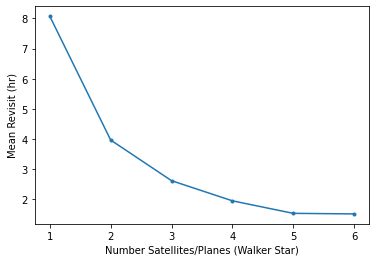

In [30]:
import numpy as np

n = np.arange(1, 7)
revisit = [
    reduce_observations(
        aggregate_observations(
            collect_multi_observations(
                hoboken,
                WalkerConstellation(
                    name="NOAA 20",
                    orbit=noaa20_orbit,
                    instruments=[viirs],
                    number_satellites=i,
                    number_planes=i,
                    configuration="star",
                ),
                start,
                end,
            )
        )
    )
    .iloc[0]
    .revisit
    / timedelta(hours=1)
    for i in n
]

import matplotlib.pyplot as plt

plt.figure()
plt.plot(n, revisit, ".-")
plt.xlabel("Number Satellites/Planes (Walker Star)")
plt.ylabel("Mean Revisit (hr)")
plt.show()